# Telco_Churn_Project:

# Overview:

# Goal: 
* 
* 

# Imports

In [2]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data Prep
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# Statistics
from scipy import stats

# Modeling

import warnings
warnings.filterwarnings("ignore")

# Custom Modules
import os
import env

In [3]:
target = 'churn'

## Planning
**Plan** --> Acquire --> Prepare --> Explore --> Model --> Deliver

* 

## Acquire
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

In [4]:
def get_connection_url(db, user=env.user, host=env.host, password=env.password):
    """
    This function will:
    - take username, pswd, host credentials from imported env module
    - output a formatted connection_url to access mySQL db
    """
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [5]:
def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection_url('telco_churn'))
    
    return df

In [6]:
def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df

In [7]:
df = get_telco_data()

## Prepare
Plan --> Acquire --> **Prepare** --> Explore --> Model --> Deliver

### STEP 1: Summarize
<b>a</b>. understand your data

<b>b</b>. visualize your variables (univariate only)

#### Step 1a. Understand Your Data:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_support 

#### Step 1b. Visualize Your Data (univariate)

In [9]:
#find only numeric columns
num_col = df.select_dtypes(include='number').columns
num_col

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'senior_citizen', 'tenure', 'monthly_charges'],
      dtype='object')

payment_type_id


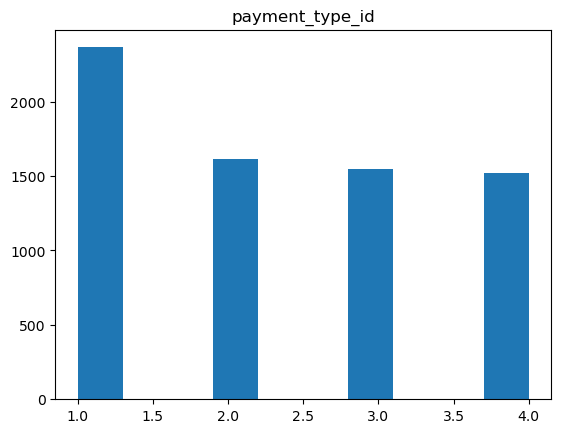

internet_service_type_id


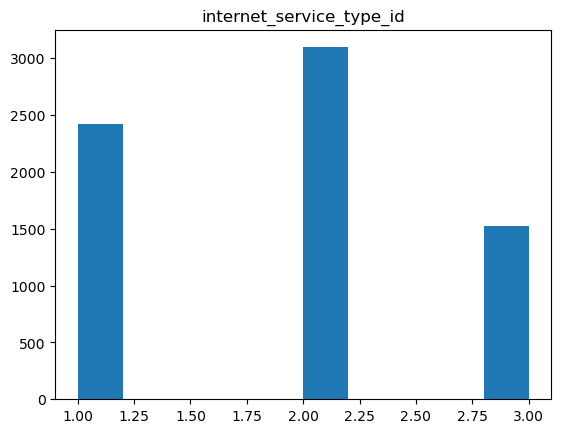

contract_type_id


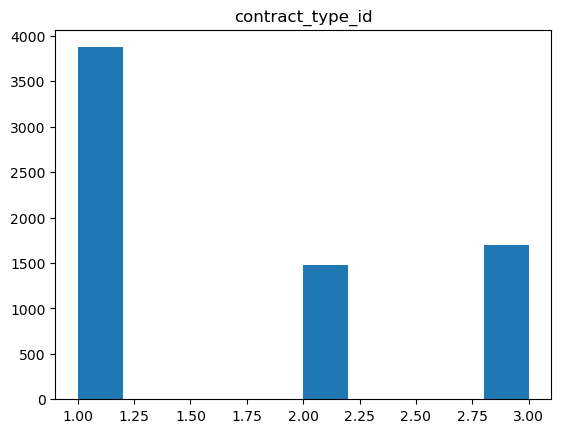

senior_citizen


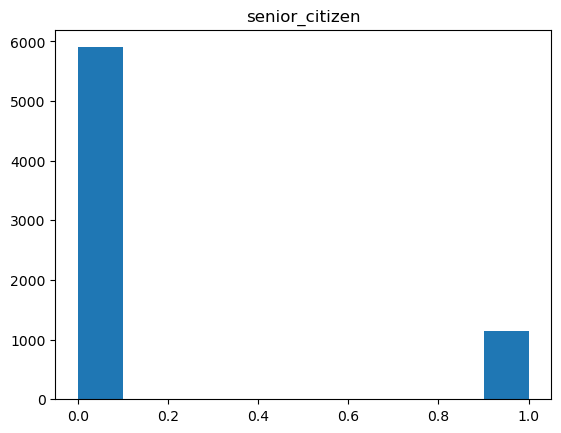

tenure


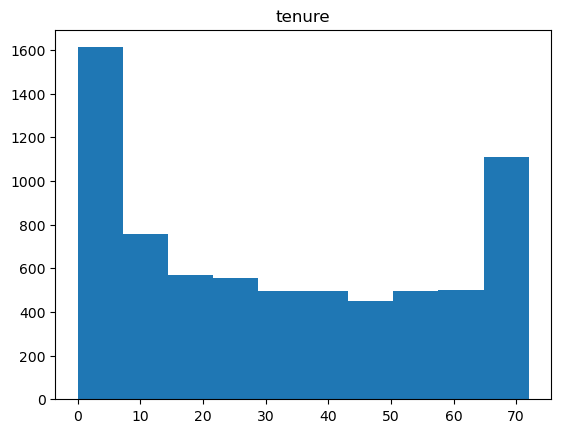

monthly_charges


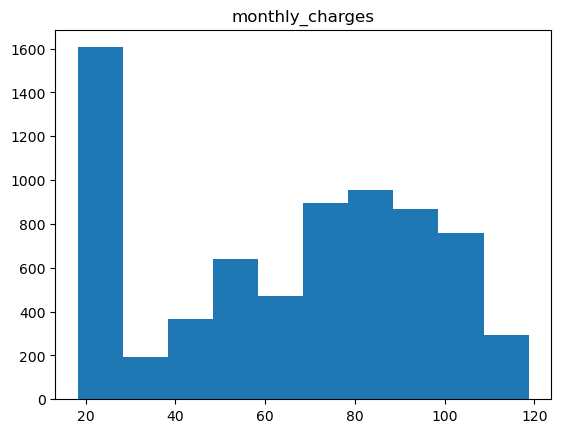

In [10]:
#plot distributions of numeric columns
for col in num_col:
    print(col)
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [11]:
#find only string columns
str_col = df.select_dtypes(exclude='number').columns
str_col

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'],
      dtype='object')

In [12]:
df.isnull().sum()

payment_type_id                0
internet_service_type_id       0
contract_type_id               0
customer_id                    0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
tenure                         0
phone_service                  0
multiple_lines                 0
online_security                0
online_backup                  0
device_protection              0
tech_support                   0
streaming_tv                   0
streaming_movies               0
paperless_billing              0
monthly_charges                0
total_charges                  0
churn                          0
contract_type                  0
internet_service_type       1526
payment_type                   0
dtype: int64

In [13]:
df.internet_service_type.value_counts(dropna=False)

internet_service_type
Fiber optic    3096
DSL            2421
NaN            1526
Name: count, dtype: int64

In [14]:
#plot distributions of string columns
'''
for col in str_col[1:]:
    print(col)
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True)) #percentage
    df[col].value_counts(dropna=False).sort_index().plot.bar()
    plt.show()
    print()
    '''

'\nfor col in str_col[1:]:\n    print(col)\n    print(df[col].value_counts())\n    print(df[col].value_counts(normalize=True)) #percentage\n    df[col].value_counts(dropna=False).sort_index().plot.bar()\n    plt.show()\n    print()\n    '

## Prepare- STEP 2: Clean the data

<b>a</b>. take care of duplicates **DROP payment_type_id, internet_service_type_id, contract_type_id**

<b>b</b>. verify datatypes **total_charges will need to be converted to float. Will need to encode any string features that we would like to inlcude.**

<b>c</b>. handle nulls **internet_service_type Is the only column with nulls. It is equivalent to internet_service_type_id, so we will just impute string "No Internet Service".**

<b>d</b>. consider outliers **No outliers.**

<b>e</b>. for modeling: make all columns numeric **Done**

### Step 2a. Duplicate Data

In [15]:
#look at data
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [16]:
df.customer_id.duplicated().sum()

0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_support 

In [18]:
#view counts across both
pd.crosstab(df.payment_type_id, df.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1612
3,1544,0,0,0
4,0,1522,0,0


In [19]:
pd.crosstab(df.contract_type_id , df.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


In [20]:
pd.crosstab(df.internet_service_type_id , df.internet_service_type)

internet_service_type,DSL,Fiber optic
internet_service_type_id,,
1,2421,0
2,0,3096


### Step 2b. Verify Datatypes

In [21]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [22]:
df.isnull().sum() [df.isnull().sum() > 0]

internet_service_type    1526
dtype: int64

### Step 2d. Outliers

In [23]:
# Looking at our initial hist plots there doesn't seem to be any outliers. However, we haven't transformed total_charges yet, so we will keep an eye on it after.

### Step 2e. For Modeling: Make all columns numeric (encode)

In [24]:
def split_function(df, target_varible):
    train, test = train_test_split(df,
                                   random_state=666,
                                   test_size=.20,
                                   stratify= df[target_varible])
    
    train, validate = train_test_split(train,
                                   random_state=666,
                                   test_size=.25,
                                   stratify= train[target_varible])
    return train, validate, test

In [25]:
def prep_telco(df):
    '''
    This function will drop any duplicate observations, split into train, val, test using split_function, impute 'internet_service_type' with "No Internet Service", drop ['contract_type_id', 'payment_type_id', 'internet_service_type_id'], create dummy vars from all categorical variables, and change dtype of total_charges to float. 
    '''
    
    # change dtype of total_charges to float
    df['total_charges'] = df.total_charges.str.replace(' ', '0').astype(float)
    
    #drop out any redundant, excessively empty, or bad columns
    df = df.drop_duplicates()
    df = df.drop(columns=['contract_type_id', 'payment_type_id', 'internet_service_type_id'])
    
    # split data into train, validate, test
    train, validate, test = split_function(df, target)
    
    # impute train['internet_service_type'] with 'No Internet Service'
    train['internet_service_type'] = train['internet_service_type'].fillna(value='No Internet Service')
    # impute train['internet_service_type'] with 'No Internet Service'
    validate['internet_service_type'] = validate['internet_service_type'].fillna(value='No Internet Service')
    # impute train['internet_service_type'] with 'No Internet Service'
    test['internet_service_type'] = test['internet_service_type'].fillna(value='No Internet Service')
    
    
    # Manually encode binary categorical variables for train
    train['gender_encoded'] = train.gender.map({'Female': 1, 'Male':0})
    train['partner_encoded'] = train.partner.map({'Yes':1, 'No':0})
    train['dependents_encoded'] = train.dependents.map({'Yes':1, 'No':0})
    train['phone_service_encoded'] = train.phone_service.map({'Yes':1, 'No':0})
    train['paperless_billing_encoded'] = train.paperless_billing.map({'Yes':1, 'No':0})
    train['churn_encoded'] = train.churn.map({'Yes':1, 'No':0})
    
    # Manually encode binary categorical variables for validate
    validate['gender_encoded'] = validate.gender.map({'Female': 1, 'Male':0})
    validate['partner_encoded'] = validate.partner.map({'Yes':1, 'No':0})
    validate['dependents_encoded'] = validate.dependents.map({'Yes':1, 'No':0})
    validate['phone_service_encoded'] = validate.phone_service.map({'Yes':1, 'No':0})
    validate['paperless_billing_encoded'] = validate.paperless_billing.map({'Yes':1, 'No':0})
    validate['churn_encoded'] = validate.churn.map({'Yes':1, 'No':0})
    
    # Manually encode binary categorical variables for test
    test['gender_encoded'] = test.gender.map({'Female': 1, 'Male':0})
    test['partner_encoded'] = test.partner.map({'Yes':1, 'No':0})
    test['dependents_encoded'] = test.dependents.map({'Yes':1, 'No':0})
    test['phone_service_encoded'] = test.phone_service.map({'Yes':1, 'No':0})
    test['paperless_billing_encoded'] = test.paperless_billing.map({'Yes':1, 'No':0})
    test['churn_encoded'] = test.churn.map({'Yes':1, 'No':0})
    
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_train = pd.get_dummies(train[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'payment_type']],
                                  drop_first=True)
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_validate = pd.get_dummies(validate[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'payment_type']],
                                  drop_first=True)
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_test = pd.get_dummies(test[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'payment_type']],
                                  drop_first=True)

    train = pd.concat([train, dummy_train], axis=1)
    validate = pd.concat([validate, dummy_validate], axis=1)
    test = pd.concat([test, dummy_test], axis=1)
    
    return train, validate, test

In [26]:
train, validate, test = prep_telco(df)

## Explore
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

 - What can we say about the data now that we have it in proper working condition?
  - Steps in this process:

1. Univariate Exploration
    - visualizations (distributive)
2. Bivariate Exploration
    - visualizations (comparative)
    - statistical testing
3. Multivariate Exploration
    - visualizations(comparative)
    - statistical testing
    - clues for feature engineering

> **EXPLORE ONLY TRAIN DATA**

### Initial Questions:
 - What features may lead to customer churn?
    - Does monthly_charges impact customer churn rate?
    - Which add-ons, if any are least associated with customer churn? Most?
    - What is the distribution of features for customers with the longest tenure?
    - What is the distribution of features for churned customers with the shortest tenure?
    - Does payment_type impact customer churn?

Step One: Univariate examination

Let's get some eyes on the spread of our features before we press forward with relationships

In [27]:
# Separate into X and y:
X_train, y_train = \
train.drop(columns=['churn_encoded', 'churn']), \
train[[target]]


In [28]:
explore_columns = X_train.drop(columns=['customer_id','gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check']).columns.to_list()

In [29]:
explore_columns

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [30]:
train[explore_columns]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,contract_type,internet_service_type,payment_type
6250,Female,0,Yes,Yes,30,Yes,No,No,No,Yes,Yes,Yes,No,Yes,64.50,1985.15,One year,DSL,Electronic check
3458,Male,0,No,No,29,Yes,Yes,No,Yes,Yes,No,No,Yes,No,70.90,1964.60,One year,DSL,Credit card (automatic)
5970,Male,0,No,No,2,Yes,No,No,Yes,No,No,Yes,Yes,No,95.65,167.30,Month-to-month,Fiber optic,Electronic check
5861,Female,0,Yes,No,72,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,24.85,1871.85,Two year,No Internet Service,Credit card (automatic)
343,Female,0,Yes,Yes,57,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,20.10,1087.70,Two year,No Internet Service,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,Female,1,No,No,64,No,No phone service,No,Yes,No,Yes,Yes,No,Yes,43.85,2751.00,Month-to-month,DSL,Electronic check
5907,Female,0,Yes,Yes,7,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,19.85,144.15,Two year,No Internet Service,Mailed check
552,Female,0,Yes,No,42,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,99.00,4135.00,Two year,Fiber optic,Credit card (automatic)
3226,Female,0,Yes,Yes,72,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,26.25,1988.05,Two year,No Internet Service,Bank transfer (automatic)


In [31]:
# separating our numeric and categorical columns:
# initialize two empty lists for each type:
cat_cols, num_cols = [], []
# set up a for loop to build those lists out:
# so for every column in explore_columns:
for col in explore_columns:
    # check to see if its an object type,
    # if so toss it in categorical
    if train[col].dtype == 'O':
        cat_cols.append(col)
    # otherwise if its numeric:
    else:
        # check to see if we have more than just a few values:
        # if thats the case, toss it in categorical
        if train[col].nunique() < 10:
            cat_cols.append(col)
        # and otherwise call it continuous by elimination
        else:
            num_cols.append(col)

In [32]:
print(cat_cols,'\n', num_cols)

['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'contract_type', 'internet_service_type', 'payment_type'] 
 ['tenure', 'monthly_charges', 'total_charges']


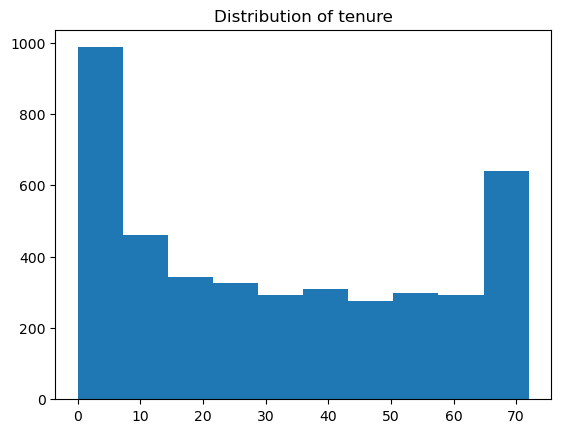

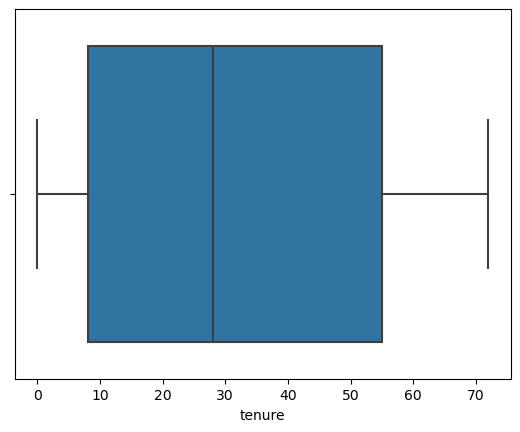

~~~~~~~~~~~~


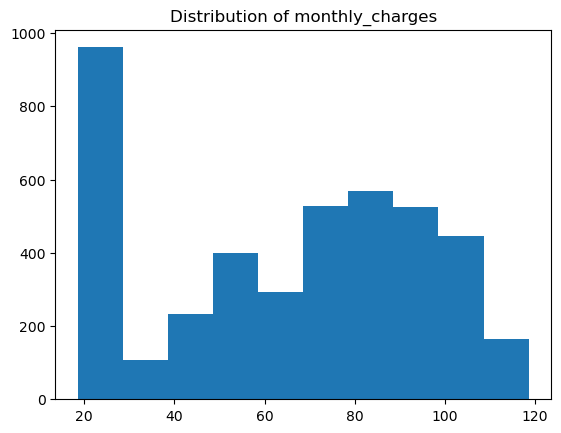

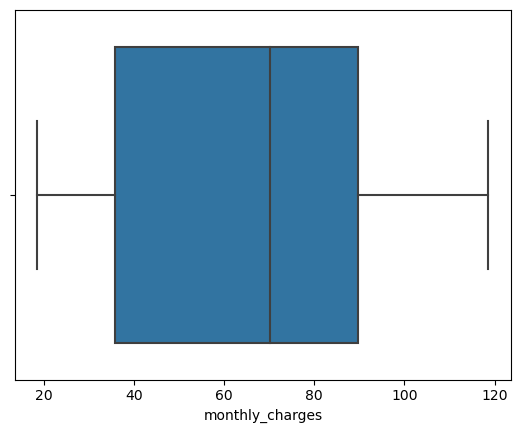

~~~~~~~~~~~~


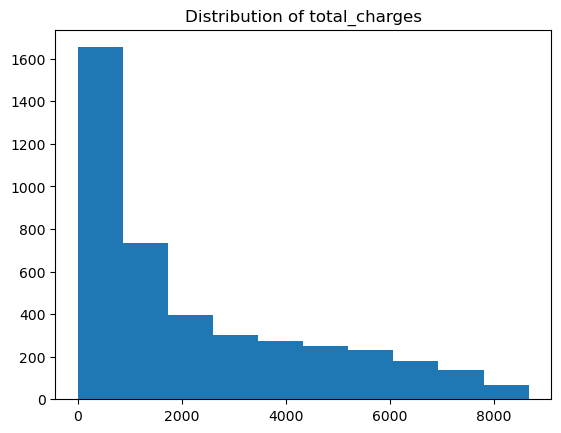

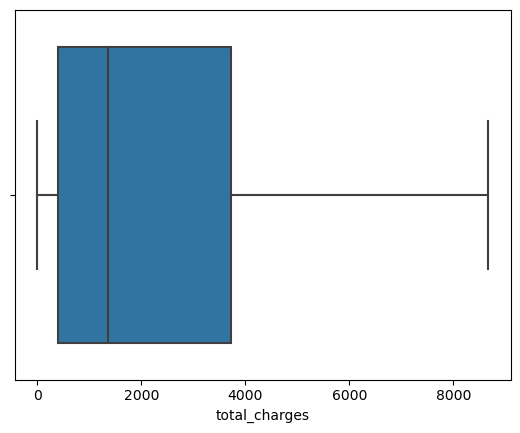

~~~~~~~~~~~~


In [34]:
# for our continuous variables,
# lets get some eyes on outliers and distributions:
for col in num_cols:
    plt.hist(train[col])
    plt.title(f'Distribution of {col}')
    plt.show()
    sns.boxplot(data=train, x=col)
    plt.show()
    print('~~~~~~~~~~~~')

In [35]:
##### Initial Takeaways for continuos variables:
# Under the Central Limit Theorem we can assume a normal sampling distribution
# For tenure: There is a big spike on the left and a smaller, but significant spike on the right.
# Monthly_Charges: Bimodal distribution with a spike on the left and another peak around 85.
# Total_Charges: Dependent on both tenure and monthly charges, it is very highly skewed, right-tailed.

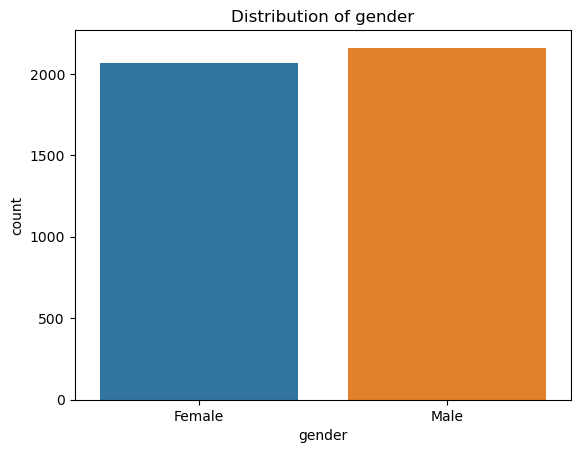

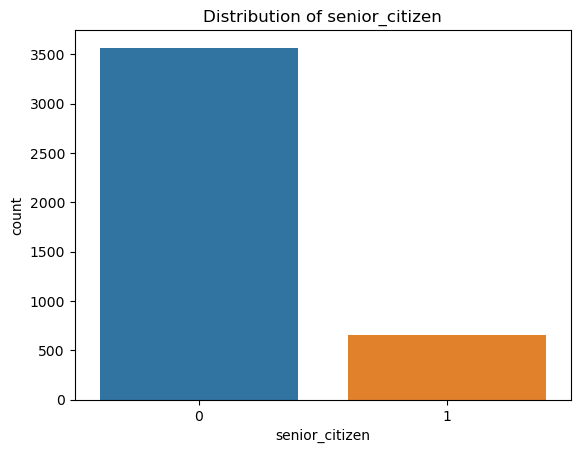

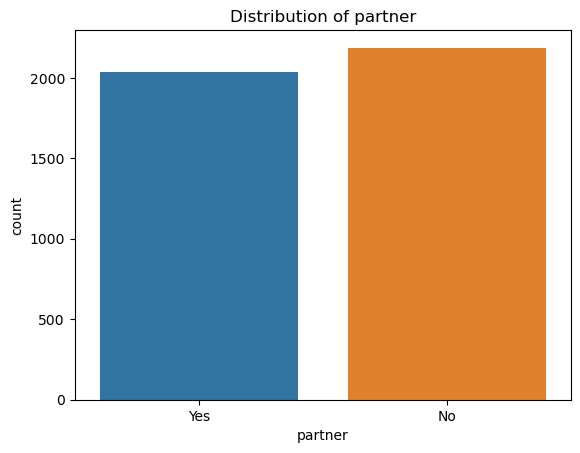

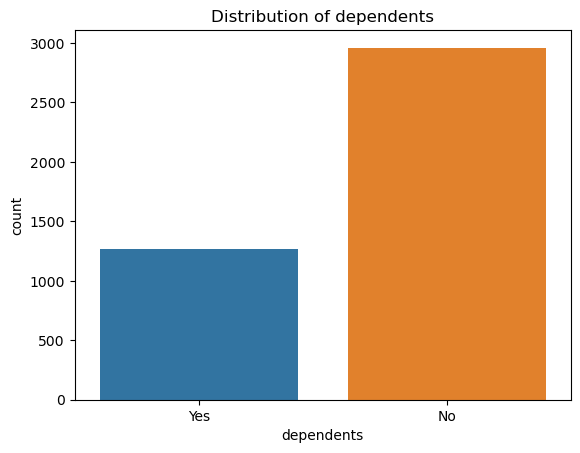

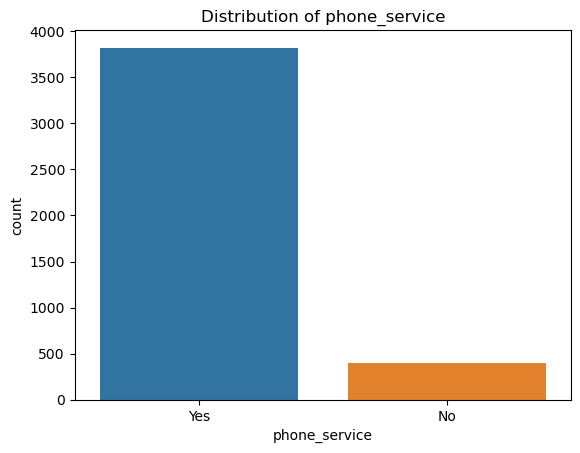

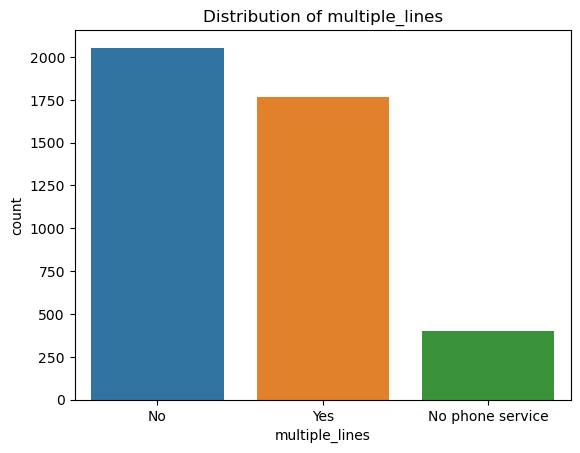

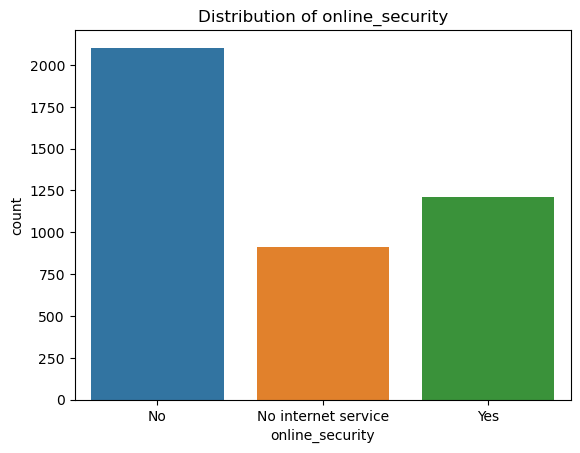

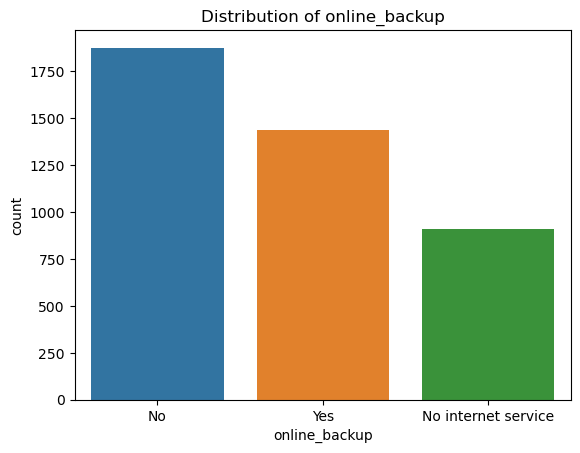

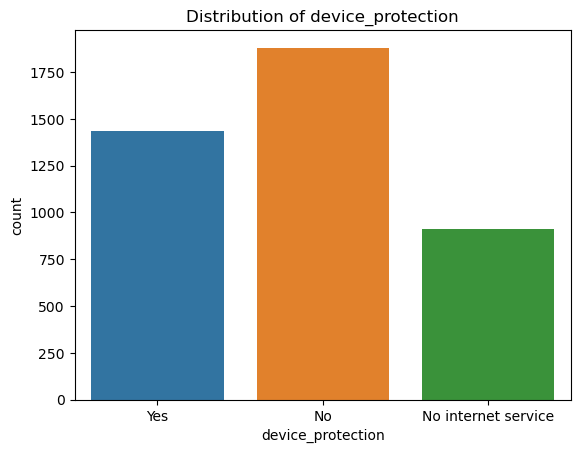

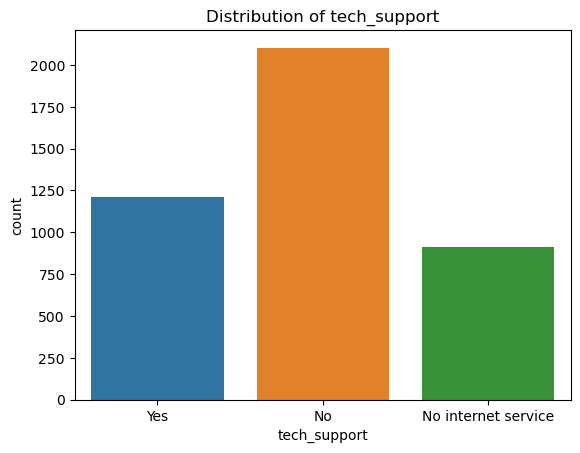

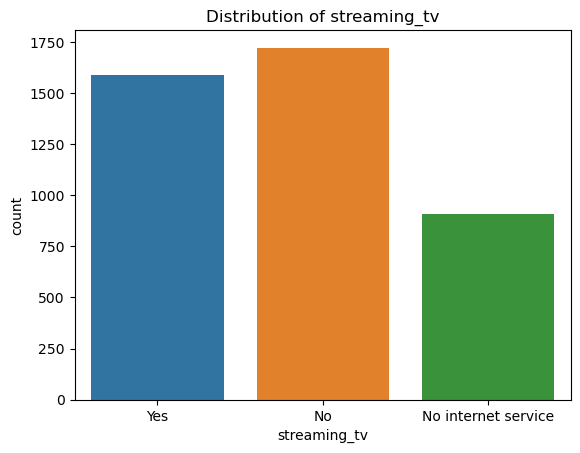

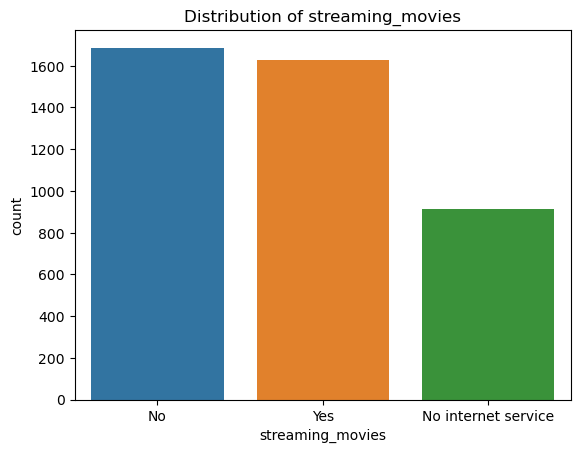

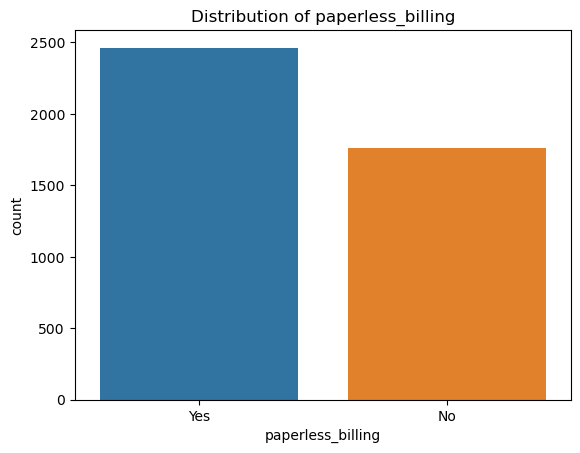

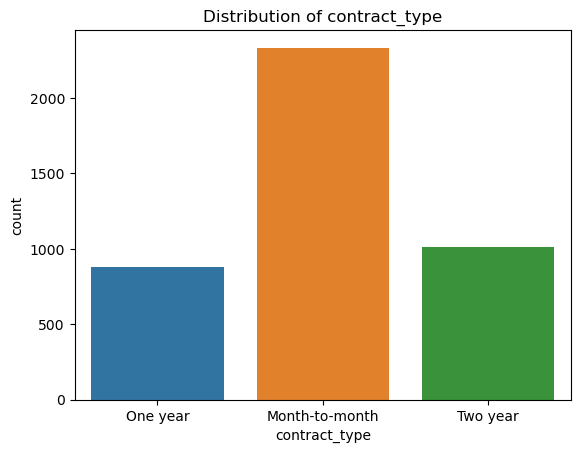

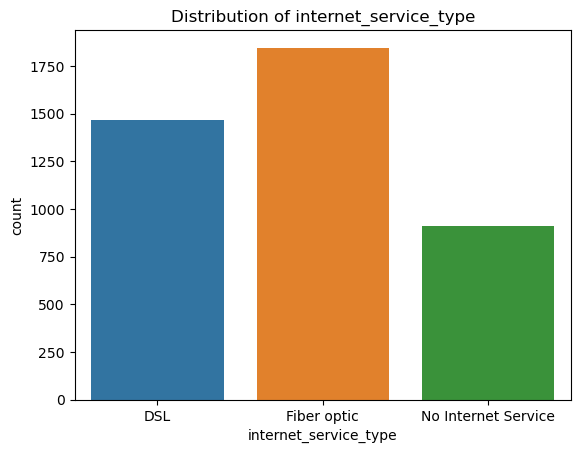

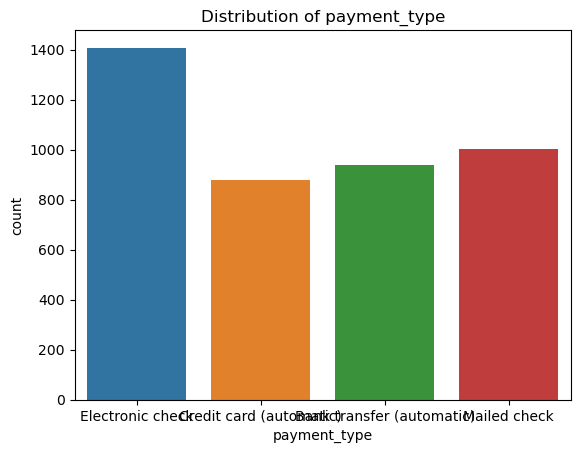

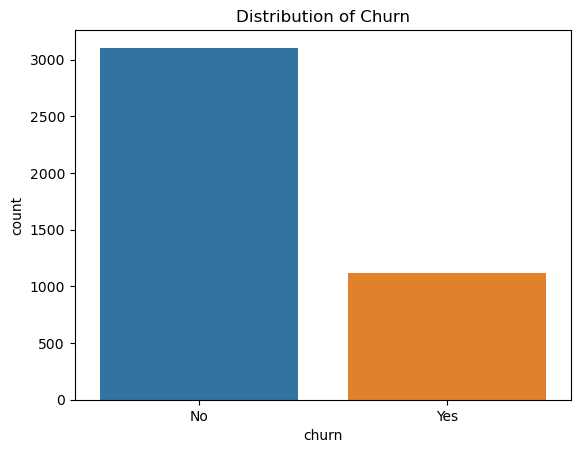

In [36]:
for col in cat_cols:
    sns.countplot(data=train, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()
sns.countplot(data=train, x=target)
plt.title('Distribution of Churn')
plt.show()

In [ ]:
# we have categories across the board that have 
# majorities in specific classes: senior_citizen -'0', dependents --'no', phone_service -'yes', contract_type-'month-to-month', churn-'no'
# It appears that the majority of customers are not senior_citizens
# It appears that the majority of customers do not have dependents
# It appears that the majority of customers have phone service
# It appears that about 21.6% of customers do not have internet service
# It appears that the number of customers with month-to-month contracts is approximate to the number of one-year and two-year combined
# Churn rate appears to be about 26.5%

### Bivariate and Multivariate Analysis:
 - How do these things interact with the target?:

     - Monthly Charges
     - add-ons: tech_support, streaming tv, multiple_lines
     - internet service type
     - payment_type

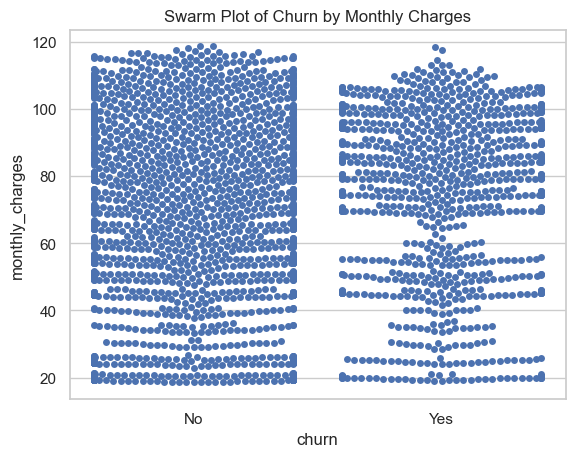

In [48]:
# Lets ask: Is the mean of monthly charges of customers who churn significantly higher than the mean across all customers?
# Visually:
# Create a swarm plot
sns.set(style="whitegrid")  # Set the style of the plot
sns.swarmplot(y='monthly_charges', x=target, data=train)

# Add labels and title
plt.ylabel('monthly_charges')
plt.xlabel(target)
plt.title('Swarm Plot of Churn by Monthly Charges')

# Show the plot
plt.show()

In [49]:
# It looks like there is a higher concentration of churned customers when monthly charges exceed ~70. 
# It looks like there are also 3 separate concentrations of churn around $45, $50, $55; could this be these be where a specific add-ons have higher churn?

In [50]:
### Lets do some stats analysis:
## continuos vs categorical:
## Enough samples under CLT to assume a normal sampling distribution:


In [53]:
#H0: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers.
#Ha: Mean of monthly charges of churned customers > Mean of monthly charges of all customers.
alpha = 0.05

In [54]:
# an array of all observed values of the subgroup
churn_sample = train[train.churn == 'Yes'].monthly_charges

# the population mean
overall_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churn_sample, overall_mean)

print(t, p/2, alpha)

12.86165366693209 1.0358740694591168e-35 0.05


In [55]:
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


In [67]:
# Lets ask: Is whether or not a customer churns independent of if they have tech support?
#H0: customer churn is independent on tech support.
#Ha: customer churn is dependent on tech support.
alpha = 0.05

In [68]:
observed = pd.crosstab(train.churn, train.tech_support)
observed

tech_support,No,No internet service,Yes
churn,,,
No,1233,843,1028
Yes,871,68,182


In [69]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [70]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[1233  843 1028]
 [ 871   68  182]]
---
Expected Values

[[1545  669  888]
 [ 558  241  321]]
---

chi^2 = 490.3965
p     = 0.0000


In [72]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


We reject the null hypothesis


# **CONTINUE LOOKING AT TECH SUPPORT. (COMPARISON OF GROUPS)**

## Model
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver

# **Notes:**
* Change payment type to auto and manual